<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/PNNPPV/notebooky/cv04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trénovanie II.

Dnes si prejdeme konvolučné neurónové siete, tzv. funkčné API kerasu, vrstvy ako BatchNorm a Dropout, augmentáciu vstupného obrazu, ostatné optimalizačné algoritmy a vyrobíme si aj vlastnú vrstvu.

In [ ]:
import keras
import numpy as np

from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout, Activation
from keras.datasets import cifar10
from keras.models import Sequential, Model

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Cifar-10

Dnes si načítame dataset cifar-10. Tento dataset obsahuje malé obrázky, ktoré su rozdelené na 10 kategórií.

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


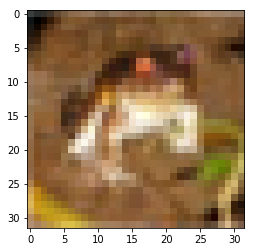

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


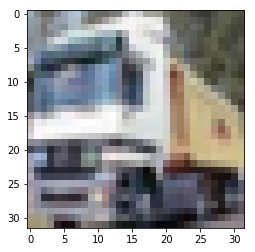

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


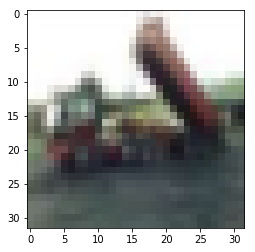

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


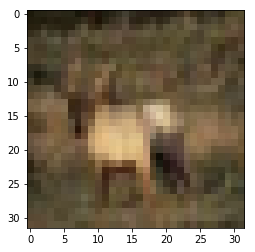

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


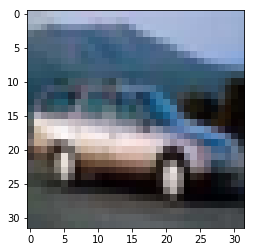

In [ ]:
(x, y), (x_test, y_test) = cifar10.load_data()

num_classes = 10

y = keras.utils.to_categorical(y, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x = x.astype('float32')
x_test = x_test.astype('float32')
x /= 255
x_test /= 255

x_val = x[:10000]
y_val = y[:10000]
x_train = x[10000:]
y_train = y[10000:]

print(x.shape)
print(x_test.shape)

for i in range(5):
  plt.imshow(x[i])
  print(y[i])
  plt.show()

## Konvolúcia

Ak by sme chceli používať pre počítačové videnie plne prepojené vrstvy, tak by sme narazili na problém s rýchlo narastajúcim množstvom parametrov. Veľké množstvo parametrov komplikuje trénovanie z hľadiska zložitosti priestoru nad ktorým optimalizujeme a taktiež vo výpočtovej náročnosti takejto optimalizácie.

Z tohto dôvodu sa najčastiejšie používajú tzv. konvolučné neurónové siete. Ich základom je konvolúcia. Tá je obecne definovaná na pre dve funkcie $f$ a $g$:

$$ (f \ast g)(t)  = \int_{-\infty}^{\infty} f(x) g(t - x) dx$$

Väčšinou sa používa ak je nosič jednej z funkcií obmedzený. V diskrétnom prípade pre "postupnosti" $a_i$ a $b_i$ pre $ i \in \mathbb{Z}$. Definujeme ako:

$$ (a \ast b)_j = \sum_{i \in \mathbb{Z}} a_i \cdot b_{j-i}$$.

V obraze však bežne však využívame dvojrozmernú verziu s veľmi malým jadrom o rozmeroch napr. $3 \times 3$, $5 \times 5$ atď. Keďže tieto jadrá sú pre bežné úlohy spracovania obrazu často symetrické, tak je bežne zamienaný pojem korelácie s konvolúciou (rozdiel je v znamienku vo výraze). Aplikáciu konvolúcie si tak môžeme predstaviť ako prenásobenie okolia nejakého bodu maskou a následné sčítanie daných hodnôt. Na obrázku znázornené ako:

![alt text](https://i.stack.imgur.com/YDusp.png)

Takýto postup sa bežne používa pri detekcii hrán, alebo iných zaujímavých bodov v obraze. Konvolúcia je preto vhodná na využitie v neurónových sieťach. To realizujeme tak, že daná vrsvta siete aplikuje na jej vstup konvolúciu s jadrom ktorého váhy sa sieť učí pri tréningu.

Aby to nebolo moc jednoduché, tak tieto jadrá niesu len dvojrozmerné (napr. $3 \times 3$), ale trojrozmerné, kde tretí rozmer korešponduje s počtom kanálov na vstupe do vrstvy. Každá vrstva má týchto jadier viacero a výstupom z nej tak bude obraz, alebo mapa príznakov s počtom kanálov rovným počtu jadier.

Pri konvolúcii ešte musíme myslieť na to čo robiť na okrajoch. Prístupy sú rôzne. Niekedy jadro prikladáme tak, že nikdy neprekočíme okraj. To ale spôsobí, že výstupný obraz bude mať iné rozmery ako vstupný. Ak nám to nevyhovuje, tak môžeme časti za okrajom obrazu považivať za nuly, prípadne brať hodnoty z opačnej strany obrazu. Pridanie núl sa označuje ako padding. Ďalšou modifikáciou je tzv. stride, teda, že jadro neprikladáme vždy o jedno políčko vedľa, ale nejaké preskočíme.

Pre jeden rozmer výstupného obrazu (samostatne šírka alebo výška) potom platí:

$$ N_{out} = \frac{N_{in} - F + 2P}{S} + 1,$$

kde $N_{out}$ je výstupná veľkosť, $N_{in}$ je vstupná veľkosť, $F$ je veľkosť jadra, $P$ je padding a $S$ je stride.

*Pozn.:* Keďže v sieti máme viacero kanálov, tak je uplne možné brať do úvahy aj $1 \times 1$ konvolúciu. Tá nam totiž len redukuje počet kanálov.



## Pooling

Konvolúcia sa často používa s tzv. poolingovými vrstvami. Tie slúžia na to, aby sa veľkosť obrazu postupne zmenšovala, čo vedie na menšie pamäťové nároky a možnosť používania viacero kanálov v hlbších vrstvách siete. Táto vrstva rozdelí obraz na zopár oblastí napr. $2 \times 2$ štvorčeky zredukuje hodnoty v nich na jedno číslo. To sa robí veľmi často pomocou operácie maxima, alebo menej často priemeru.

![alt text](https://qph.fs.quoracdn.net/main-qimg-cf2833a40f946faf04163bc28517959c)

## Flatten a Globálny Pooling

Na konci sieťe je veľmi bežné použiť zopár plne prepojených vrstiev. Na to je však potrebné redukovať počet dimenzií (rád tenzoru). K tomu slúži vrstva Flatten, ktorá príznaky zoradí z obrazovej reprezentácie do vektoru.

Nie vždy je vhodné využiť takýto prístup keďže veľkosť vektoru potom môže byť strašne veľká. Namiesto toho sa tak často používa tzv. globálny pooling, ktorý funguje ako bežný pooling ale redukuje celý obraz prináležiaci jednému kanálu na jedno číslo. Tu sa narozdiel od bežného Poolingu používa často priemerovací pooling.

## Aktivačné funkcie

Výber aktivačnej funkcie je dôležitý pri konštrukcii architektúr hlbokých neurónových sietí. Viac sa s nimi zoznámite počas domácej úlohy. Dnes budeme používať aktivačnú funkciu ReLU (rectified linear unit), ktorá ma nazrozdiel od sigmoidu výhodu v tom, že sa veľmi rýchlo počíta a jej derivácia je buď jedna, alebo nula, čo pomáha riešiť problém tzv. miznúcich gradientov, ktorý nastáva pri využití sigmoidu. Preto budeme v dnešnom notebooku používať ReLU.

ReLU je síce populárna, ale má niektoré nie uplne vhodné vlastnosti. Tie riešia rôznymi spôsobmi jej variácie PReLU, ELU a Leaky ReLU s ktorými sa zoznámite v rámci domácej úlohy. 

## Optimalizácia

Zatiaľ sme používali na optimalizáciu SGD. To je ale veľmi senzitívne na nastavenie trénovacieho kroku. V dnešnom cvičení použiejeme metódu Adam. Rôzne metódy optimalizácie aj to ako reagujú na hyperparametre si takisto overíte v rámci domácej úlohy.

## Jednoduchý model CNN

Navrhneme si jednoduchý model pre konvolučnú neurónovú sieť.

Pre konvolučné vrstvy je prvý parameter počet konvolučných jadier. Ďalšie parametre sú veľkosť jadier, padding, stride atď pre viac info konzultujte dokumentáciu.

Pre poolingové vrsvy je to veľkosť poolingového okna.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3), activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)             

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=32,
          epochs=30,
          validation_data=(x_val, y_val),
          shuffle=True)

## Augmentácia dát

Na vylepšenie modelu by bolo dobré mať viac dát. Tie však len tak zohnať nevieme. Preto si pomôžeme augmentáciou. Tá spočíva v aplikácii transformácií, ktoré nemenia sémantický obsah obrazu. Augmentácia sa dá poňať aj tak, že chceme aby naša sieť bola invariantná voči týmto transformáciám.

Prakticky využijeme augmentáciu tak, že použijeme tzv. ImageDataGenerator namiesto jednoduchého x_train a y_train. Validáčne dáta neaugmentujeme, niekedy to ale môže tiež byť užitočné. Problém nastáva ak si generátor ukladá nejaké parametre ako napríklad parametre na normalizáciu vstupu. Často je najlepšie napísať si vlastný generátor to budeme robiť nabudúce.


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.,
    zoom_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,  # randomly flip images
    preprocessing_function=None)

# Toto voláme aby sme nastavili paramtere pre iné parametre generátora
# ako napríklad úpravu dát na stredovanie, alebo delenie št. odchylkou
# Pozn. ak spravíme toto tak pri aplikácii siete je nutné obraz najprv
# upraviť pomocou x = datagen.standarize(np.copy(x))
# datagen.fit(x_train)


model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# namiesto fit používame fit_generator, ktorý vytvoríme pomocou metódy
# flow na trénovacie dáta. Validačné necháme tak
model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=32),
                    epochs=30,
                    validation_data=(x_val, y_val),
                    workers=4)

## Dropout

Minule sme si ukazovali L1 a L2 regularizáciu. Dnes si ukážeme metódu Dropout. Tá spočíva v tom, že niektoré prepojenia (s pravedepodobnosťou $p$) sieť nastaví na nulu. To zabráni koadaptácii príznakov. Teda ak náhodou dva príznaky reprezentujú do isté, tak by sa nemali šancu naučiť každý niečo iné, lebo vždy budú ich gradienty a teda aj zmena po každom kroku rovnaká (aspoň približne). Ak však pridáme dropout majú tieto príznaky možnosť sa odlúčiť od seba, čo je pozitívne. Iný pohľad na vec je taký, že vlastne trénujeme viacero modelov naraz (tj. toľko modelov koľko existuje kombinácii kde sa niektore váhy ignorujú) a na konci ich spojíme a spriemerujeme ich výsledok.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=32),
                    epochs=30,
                    validation_data=(x_val, y_val),
                    workers=4)

## BatchNormalization

Normalizácia dávok rieši problém vnútorného kovariančného posunu (internal covarience shift) v rámci siete. Ten spôsobuje že príznaky nemajú vhodnú distribúciu v rámci siete. To je dôležité najmä pre hlbšie siete.

BatchNorm funguje tak, že pre každý minibatch sa vypočíta stredná hodnota a štandardná odchylka príznakov na danej vrstve. Príznaky sa potom normalizujú odčítanim priemeru a podelením štd. odchylkou:

$$\hat{x} = \frac{x - \bar{x}}{\sqrt{\sigma^2(x) + \epsilon}}.$$

Keďže však normálna distribúcia nieje vždy žiadúca má táto vrstva ešte dva trénovateľné parametre $\gamma$ a $\beta$:

$$y = \gamma \hat{x} + \beta.$$

To umožní naučiť sa iný tvar distribúcie, ktorý je pre sieť vhodnejší.

Pri inferencii nedostávame dávku, resp. ju nedostávame náhodne. Preto si vrstva po trénovaní pamätá priemer a štd. odchylku.

BatchNorm sa bežne aplikuje pred activačnou funkciou. Doteraz sme ju mali určenú v inej vrstve teraz ju spravíme samostatne.



In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Domáca úloha

Prvá domáca úloha bude spočívať v praktickom testovaní vecí, ktoré sme si práve spomínali. Je rozložená na viaceré časti. Výstupom z úlohy môže byť buď viacero notebookov, alebo python skriptov, ktorými ste spúštali experimenty. Výstupom má byť takisto pdf súbor s výsledkami a grafmi, ktoré budú demonštrovať vaše tvrdenia.

Jadrom domácej úlohy bude trénovanie siete na datasete Cifar-10. Vždy potom budete porovnávať ako rôzne modifikácie siete fungujú voči iným prípadne voči nejakému baselinu. Úloha sa bude skladať z viacerých častí.

### Základný model (1b)

Cieľ je navrhnúť idálne čo najrýchlejší model, ktorý bude dosahovať cca. 70 percentnú presnosť na datasete Cifar-10. Tento model bude slúžiť ako baseline pre ďalšie modifikácie. V rámci modelu použite optimalizátor Adam a aktivácie ReLU. Začiatok modelu by mal pozostávať zo zopár konvolučných a poolingových vrstiev. Na konci by mala byť plne prepojená časť.

V naselujúcich podúlohách je nutné zmeniť vždy nejakú časť modelu a porovnať ich navzájom pomocou grafov, ktoré ukazujú vývoj validačnej presnosti a chyby. Namiesto grafov je možné použiť tabuľku, ale v nej je zmysluplné uvádzať len hodnoty na konci trénovania.

### Aktivácie (3b)

Vyskúšajte vymeniť aktivačné funkcie. Otestujte tri z nasledovných aktivačných funkcií sigmoid, tanh, ELU, LeakyReLU a PReLU. LeakyReLU môžete otestovať aj pre rôzne hodnoty parametru alpha (napr. 0.3, 0.1, 0,03). 

PReLU a LeakyReLU je treba použiť špeciálne podľa [dokumentácie](https://keras.io/layers/advanced-activations/)

### Optimalizácia (6b)

Otestujte trénovanie pomocou optimalizátorov Adam, SGD alebo RMSProp. Spustite aspoň 4 rôzne konfigurácie (rôzne kroky, rôzne alpha, beta atď). Pre túto úlohu je vhodné využiť v pdfku grafy. 

Jednu metódu si vyberte a otestujte pre ňu navyše ďalšie tri veľkosti minibatchov.

### Dropout a Augmentácia (6b)

Dropout otestujte tak, že bude najprv len v plne prepojenej vrstve (p = 0.5) a potom aj po konvolučných vrstvách (p = 0.2). A ešte jednu možnosť navyše.

Augmentáciu testujte pre 3 rôzne nastavania. Môžte byť aj kreatívny, ale malo by to mať aspoň nejaký zmysel.

Obe veci testujte pre dva prípady v jednom použijete bežný split na train/val a v druhom nechajte v trénovacej množine iba prvých 1000 príkladov. Uvedomte si, že počet trénovacích krokov je pre druhý prípad menší použite preto viac epôch, alebo nastavte trénovanie na kroky nie podľa minibatch.

### Hlboká sieť (5b)

Navrhnite hlbokú (stačí aj úzku, ale nech má aspoň 11 vrstiev) sieť. Otestujte ju najprv bez BatchNorm, reziduálnych alebo dense prepojení, alebo prídavných trenovacích vrstiev. Nakoniec otestujte aspoň dva z týchto prístupov, tak aby ste mali aspoň 3 rôzne modely (tj. rôzne rozmiestnenie týchto prvkov).

Pozn.: Ak chcete testovať reziduálne, alebo dense prepojenia, tak navrhnite sieť tak, aby ich bolo kam dať.

### Najlepší model (3b)

Vytvorte model, ktorý dosiahne najlepší vylsedok, aký len viete. Tieto body sú navyše a nerátajú sa do celkového počtu bodov. Bude sa prihliadať na to aké modely odovzdali ostatní. Model zašlite vo formáte h5 v prílohe spolu s notebookmi a pdfkom. Váš postup pre tvorbu modelu popíšte. Môžete sa inšpirovať internetom, ale nesťahujte ani nepoužívajte predtrénované modely. Ak už sa inšpirijete niečim až príliš, tak aspoň popíšte prečo by práve ten model mal fungovať dobre (tu prosím nepíšte, že preto že blog to tvrdí).

## Hodnotenie

Úloha je relatívne priamočiara, keďže jej cieľ je skôr nadobudnutie skúseností. Problém bude skôr s časom. Pri úlohách si môžete väčšinou vybrať viacere parametre. Preto nevadí ak niektoré z nich budú nezmyselné ako napr. veľmi veľký krok učenia, keďže vedieť co nefunguje je tiež dôležité. Budem však strhávať body ak v nejakej sekcii nebudú skoro žiadne nastavenia, ktoré dávaju zmysel/dobré výsledky. Ideálne by bolo ak by ste sa snažili napr. po prvých troch nastaveniach snažili nájsť to "najlepšie". Súčasťou pdfka, ktoré odovzdáte bude aj komentár, ak sa v ňom vyskytne nejaký nezmysel, tak tiež budem strhávať.

## Odovzdávanie

Úlohu odovzdajte v zipe s notebookmi/skriptami, pdfkom s výsledkami a vašim modelom na mailovú adresu kocurvik@gmail.com Pdfko rozdelte na sekcie ako tu a ideálne aj do podeskcií kde to dáva zmysel. K výsledkom vždy vypíšte komentár ako dopadli.

Deadline je do **6.11. 23:59**. Ak nebudete stíhať, tak pri neskoršom odovzdaní budem strhávať body.




# Funkčné modely v kerase

Teraz si ukážeme ako vytvoriť tzv. funkčný model v kerase. Ten umožňuje zostaviť výpočtový graf inak ako sekvenčne. Funguje to tak, že všetky vrstvy (aj modely, ktoré sa dajú použiť ako vrstvy) sú callable. Ak ich zavoláme na nejaký inú vstrtvu tak sa medzi nimi vytvorí prepojenie v grafe. Jednu inštanciu vrstvy môžeme použiť aj opakovane vtedy sa použijú rovnaké váhy. Ako príklad si uvedieme jednoduchý model pre dataset MNIST.

In [ ]:
from keras.datasets import mnist

(x, y), (x_test, y_test) = mnist.load_data()
x = np.reshape(x,(-1,784)).astype(np.float32) / 255
x_test = np.reshape(x_test,(-1,784)).astype(np.float32) / 255
y = keras.utils.to_categorical(y)
y_test = keras.utils.to_categorical(y_test)

x_train = x[:50000]
y_train = y[:50000]
x_val = x[50000:]
y_val = y[50000:]

11493376/11490434 [==============================] - 0s 0us/step


Aby sme mohli vytvoriť vstup potrebujeme vrstvu Input. Vstupov vo funkčnom modeli môže byť viacej. Model potom vytvoríme pomocou vytvorenia inštancie model, ktorá ma ako argumenty vstupy a výstupy.

In [ ]:
from keras.layers import Input
from keras.models import Model

In [ ]:
inputs = Input(shape=(784,))

output_1 = Dense(64, activation='relu')(inputs)
output_2 = Dense(64, activation='relu')(output_1)
predictions = Dense(10, activation='softmax')(output_2)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train) 



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





31488/50000 [=================>............] - ETA: 5s - loss: 0.3587 - acc: 0.8973

KeyboardInterrupt: ignored

Na tomto zatiaľ nieje nič zaujímavé avšak model môžeme vyrobiť aj komplikovanejší. Napríklad budeme chcieť aby náš model robil dve veci a to klasifikoval číslo a zároveň odhadol, či je párne alebo nepárne.

Najprv pripravíme lable pre to, či je číslo párne. 

In [ ]:
def odd_even(y):
  arg = np.argmax(y, axis = -1)
  return np.where(arg % 2 == 0, 1, 0)

y2 = odd_even(y)
y2_train = y2[:50000]
y2_val = y2[50000:]
y2_test = odd_even(y_test)

print(y2_val)

[0 1 1 ... 0 1 1]


Teraz vytvoríme model. Keďže budeme chcieť aby sme si pozreli ako model vyzerá, tak si vrstvy pomenujeme, aby sme sa v ňom vyznali.

Na konci potom máme dva výstupy. Do Model potom posielame zoznam s výstupnými tenzormi a ako loss posúvame do metódy compile zoznam s cenovými funkciami. Do metódy fit potom tiež posielame zoznam s trénovacími labelmi.

In [ ]:
input_1 = Input(shape=(784,), name='input_1')
hidden_1_out = Dense(30, activation='relu', name='hidden_1')(input_1)
hidden_2_out = Dense(30, activation='relu', name='hidden_2')(hidden_1_out)

hidden_class_out = Dense(20, activation='relu', name='hidden_class')(hidden_2_out)
predict_class_out = Dense(10, activation='softmax', name='predict_class')(hidden_class_out)

hidden_pair_out = Dense(20, activation='relu', name='hidden_pair')(hidden_2_out)
predict_pair_out = Dense(1, activation='sigmoid', name='predict_pair')(hidden_pair_out)

model = Model(inputs=input_1, outputs=[predict_class_out, predict_pair_out])

model.compile(optimizer='adam', loss= ['categorical_crossentropy', 'binary_crossentropy'], loss_weights=[0.2, 1], metrics=['accuracy'])

print(model.summary())

model.fit(x_train, [y_train, y2_train], validation_data = (x_val,[y_val, y2_val]), batch_size=32, epochs=10)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 30)           23550       input_1[0][0]                    
__________________________________________________________________________________________________
hidden_2 (Dense)                (None, 30)           930         hidden_1[0][0]                   
__________________________________________________________________________________________________
hidden_class (Dense)            (None, 20)           620         hidden_2[0][0]                   
____________________________________________________________________________________________

KeyboardInterrupt: ignored

Model si môžeme aj vyzualizovať. Pomocou funkcie plot model.

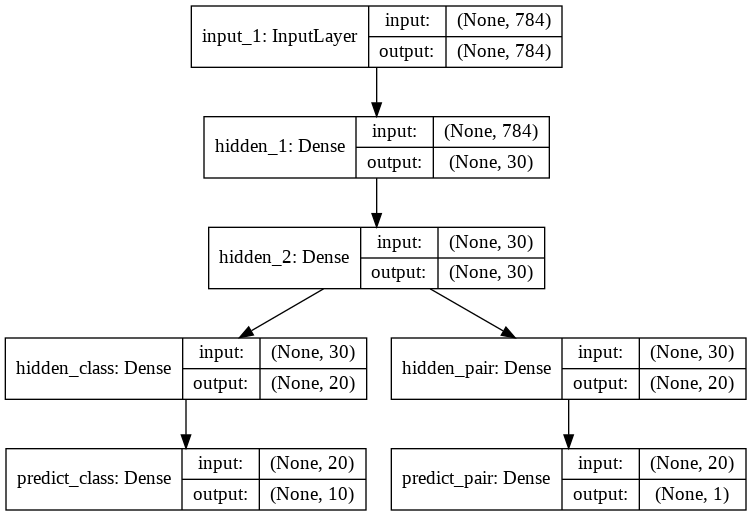

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

Model môžeme otestovať na testovacích dátach.

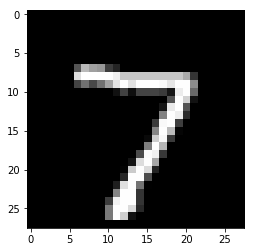

7
6.3206176e-06


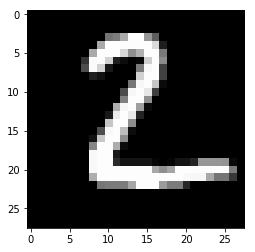

2
0.9899795


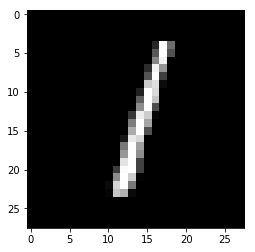

1
0.0011176873


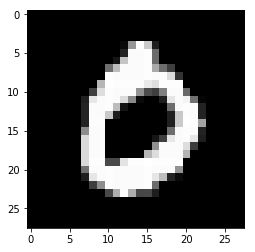

0
0.9997205


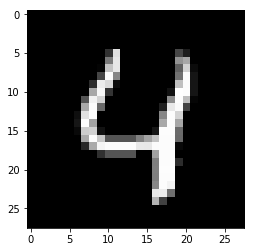

4
0.9682428


In [ ]:
for i in range(5):
  out = model.predict(x_test[np.newaxis,i,:])
  plt.imshow(np.reshape(x_test[i],(28,28)), cmap='gray')
  plt.show()
  print(np.argmax(out[0]))
  print(out[1][0,0])

## Úloha 1

Vytvorte model, ktorý na vstup zoberie dve čísla a na výstupe bude klasifikovať do dvoch tried (0 a 1), či je ich súčet väčší ako 10, alebo nie. Normálne by sme dáta generovali generátorom, teraz nám však stačí ak si čísla nádhodne popárujeme. Poprehadzovanie hodnôt sa urobí pomocou permutácie indexu. Pozor je nutné permutovať x a y rovnako.

In [ ]:
idxs = np.random.permutation(60000)
x2 = x[idxs,:]
y2 = y[idxs,:]

idxs_test = np.random.permutation(10000)
x2_test = x[idxs_test,:]
y2_test = y[idxs_test,:]

Teraz vyrobte funkciou ktorá vám vyrobí y pre váš model.

In [ ]:
def get_above10(y1, y2):
  ...

In [ ]:
y_above10 = get_above10(y,y2)
y_above10_test = get_above10(y_test,y2_test)

x2_train = x2[:50000]
y_above10_train = y_above10[:50000]
x2_val = x2[50000:]
y_above10_val = y_above10[50000:]

V nasledujúcom bloku vytvorte kód sieť ktorá bude mať dva vstupy. Tieto dva vstupy potom samostatne pôjdu do vrstiev s rovnakými váhami. Teda je nutné vyrobiť inštanciu nejakej vrstvy a raz ju zavolať na jeden vstupný tenzor a potom na druhý. Takéto "spoločné ale samostatné" vrstvy budeme mať dve. Ak to nieje jasné pozrite si [dokumentáciu.](https://keras.io/getting-started/functional-api-guide/)

Následne je nutné tieto dve vetvy spojiť. To spravíme pomocou vrsvty keras.layers.concatenate, ktorá má ako prvý argument zoznam vrstiev na spojenie.

Zvyšok je potom jednoduchý. Trénovanie je podobné predchádzajúcemu príkladu, zoznam však tentokrát bude vždy na vstupoch.

In [ ]:
...


Váš výtvor si overíme.

In [ ]:
for i in range(5):
  out = model.predict([x_test[np.newaxis,i,:], x_test[np.newaxis,i+500,:]])
  plt.imshow(np.reshape(x_test[i],(28,28)), cmap='gray')
  plt.show()
  plt.imshow(np.reshape(x_test[i+500],(28,28)), cmap='gray')
  plt.show()
  print(out[0,0])

## Úloha 2

Pre túto aj ďalšie úlohy budeme modifikovať kód siete uvedený nižšie. Takisto sa vrátime k datasetu Cifar-10

V tejto úlohe bude cieľom vytvoriť tzv. reziduálne prepojenie. To je charakterizované ako sčítanie výstupu jednej vrstvy s nejakou vrstvou ktorá je v modeli neskôr. Na to aby to šlo samozrejme musia mať rovnaké rozmery. Pri konvolúciach potom používame padding='same'. Ak chceme mať rôzny počet kanálov, tak použijeme $1 \times 1$ konvolúciu. Na sčítanie výstupov z dvoch vrstiev použite keras.layers.add

![alt text](https://miro.medium.com/max/1226/1*zS2ChIMwAqC5DQbL5yD9iQ.png)

Kto skončí môže spraviť namiesto resnet layers tzv. dense bloky kde sa namiesto súčtu vrstvy len spoja teda použije sa keras.layers.concatenate.

In [ ]:
from keras.layers import GlobalAveragePooling2D

In [ ]:
(x, y), (x_test, y_test) = cifar10.load_data()

num_classes = 10

y = keras.utils.to_categorical(y, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x = x.astype('float32')
x_test = x_test.astype('float32')
x /= 255
x_test /= 255

x_val = x[:10000]
y_val = y[:10000]
x_train = x[10000:]
y_train = y[10000:]

In [ ]:
def res_layer(h_filters, out_filters, reduce_vol = False):
  
  def _f(x):
    ...
  return _f

In [ ]:
input_1 = Input(shape=(32,32,3))
out_1 = Conv2D(32,(3,3), padding='same', activation='relu')(input_1)
out_2 = res_layer(32,32)(out_1)
out_3 = res_layer(32,32)(out_2)
out_4 = res_layer(64,32(out_3)

out_4_1 = GlobalAveragePooling2D()(out_4)
out_4_2 = Dense(64, activation='relu')(out_4_1)
out_4_3 = Dense(32, activation='relu')(out_4_2)
out_4_3 = Dense(10, activation='softmax')(out_4_3)

model = Model(input=input_1, output=out_4_3)

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])
print(model.summary())

model.fit(x_train, y_train,
          batch_size=32,
          epochs=30,
          validation_data=(x_val, y_val),
          shuffle=True)

Teraz doimplementujte aj prípad kde budeme redukovať rozmery obrazu. To spravíme pomocou stridu pri prvej vrsvte bloku. Pri sčítaní potom na pôvodný vstup ešte aplikujeme znova stride. Upravte funkciu ktorá vráti blok, tak aby toto robila ak bude reduce_vol True.

In [ ]:
input_1 = Input(shape=(32,32,3))
out_1 = Conv2D(32,(3,3), padding='same', activation='relu')(input_1)
out_2 = res_layer(32,32)(out_1)
out_3 = res_layer(64,32)(out_2)
out_4 = res_layer(64,64,reduce_vol=True)(out_3)

out_5 = res_layer(64,64)(out_4)
out_6 = res_layer(128,64)(out_5)
out_7 = res_layer(128,128,reduce_vol=True)(out_6)

out_7_1 = GlobalAveragePooling2D()(out_7)
out_7_2 = Dense(64, activation='relu')(out_7_1)
out_7_3 = Dense(32, activation='relu')(out_7_2)
out_7_3 = Dense(10, activation='softmax')(out_7_3)

model = Model(input=input_1, output=out_7_3)

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])
print(model.summary())

model.fit(x_train, y_train,
          batch_size=32,
          epochs=30,
          validation_data=(x_val, y_val),
          shuffle=True)

## Úloha 3

Na trénovanie hlbokých sietí dávnejšie používali tzv. prídavné (auxillary) trénovacie vrstvy ktoré majú vlastnú cenovú funkciu. Navrhnite hlbšiu neurónovú sieť a pridajte jej prídavné výstupné vrstvy. 

In [ ]:
...